# M.A.R.L.IN eDNA Species Classifier - Sequence Clustering

## Overview
This notebook performs unsupervised clustering of DNA sequences to identify potential novel taxa and group similar sequences. The clustering approach is designed to work with the challenges of deep-sea eDNA data where reference databases may be incomplete.

## Clustering Approaches
1. **DBSCAN**: Density-based clustering for finding clusters of varying densities
2. **HDBSCAN**: Hierarchical extension of DBSCAN for better parameter selection
3. **K-means**: Traditional clustering for comparison
4. **Gaussian Mixture Models**: Probabilistic clustering approach
5. **Agglomerative Clustering**: Hierarchical clustering for taxonomic relationships

## Goals
- Identify clusters representing potential species or taxa
- Detect novel sequences that don't fit known patterns
- Generate consensus sequences for each cluster
- Assign confidence scores and novelty metrics
- Prepare data for taxonomic classification and analysis

## Novelty Detection
- Sequences in small clusters may represent novel taxa
- Outliers and noise points indicate potential new species
- Distance-based novelty scoring for each sequence

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from collections import Counter, defaultdict

# Clustering libraries
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import hdbscan

# Analysis libraries
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import umap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Biological sequence analysis
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set up paths
BASE_DIR = Path("../data")
PROCESSED_DIR = BASE_DIR / "processed"
EMBEDDINGS_DIR = BASE_DIR / "embeddings"
MODEL_DIR = Path("../model")
CLUSTER_DIR = MODEL_DIR / "cluster_models"

# Create directories
CLUSTER_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")
print(f"Processed data directory: {PROCESSED_DIR}")
print(f"Embeddings directory: {EMBEDDINGS_DIR}")
print(f"Cluster models directory: {CLUSTER_DIR}")

/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. 

Libraries imported successfully!
Processed data directory: ../data/processed
Embeddings directory: ../data/embeddings
Cluster models directory: ../model/cluster_models


/run/media/spidey/35f48b83-0fe4-4b1f-ba92-81ad5e6b81f61/M.A.R.L.IN-edna-species-classifier/backend/.venv/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
# Load embeddings and sequence data
print("Loading embeddings and sequence data...")

try:
    # Load sequence embeddings
    with open(EMBEDDINGS_DIR / "sequence_embeddings.pkl", 'rb') as f:
        embeddings_data = pickle.load(f)
    
    # Load clustering embeddings (PCA reduced)
    clustering_embeddings = np.load(EMBEDDINGS_DIR / "clustering_embeddings.npy")
    
    # Load sequence data
    with open(PROCESSED_DIR / "sequences_with_embeddings.pkl", 'rb') as f:
        df_sequences = pickle.load(f)
    
    print(f"Loaded embeddings for {len(df_sequences)} sequences")
    print(f"Clustering embeddings shape: {clustering_embeddings.shape}")
    print(f"Original embeddings shape: {embeddings_data['original_embeddings'].shape}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run the preprocessing and embedding notebooks first!")
    sys.exit(1)

# Get metadata
sequence_ids = embeddings_data['sequence_ids']
databases = embeddings_data['databases']
umap_embeddings = embeddings_data['umap_embeddings']

print(f"Database distribution: {Counter(databases)}")
print(f"Sequence length range: {df_sequences['length'].min()}-{df_sequences['length'].max()} bp")

Loading embeddings and sequence data...
Loaded embeddings for 15000 sequences
Clustering embeddings shape: (15000, 50)
Original embeddings shape: (15000, 1344)
Database distribution: Counter({'16S_ribosomal_RNA': 5000, '18S_fungal_sequences': 5000, '28S_fungal_sequences': 5000})
Sequence length range: 200-1499 bp
Loaded embeddings for 15000 sequences
Clustering embeddings shape: (15000, 50)
Original embeddings shape: (15000, 1344)
Database distribution: Counter({'16S_ribosomal_RNA': 5000, '18S_fungal_sequences': 5000, '28S_fungal_sequences': 5000})
Sequence length range: 200-1499 bp


In [3]:
class SequenceClusterer:
    """Comprehensive sequence clustering with multiple algorithms"""
    
    def __init__(self, embeddings, sequences_df):
        self.embeddings = embeddings
        self.sequences_df = sequences_df
        self.clusterers = {}
        self.cluster_results = {}
        self.cluster_metrics = {}
        
    def optimize_dbscan_parameters(self, sample_size=1000):
        """Optimize DBSCAN parameters using k-distance plot"""
        print("Optimizing DBSCAN parameters...")
        
        # Sample data for parameter optimization
        if len(self.embeddings) > sample_size:
            indices = np.random.choice(len(self.embeddings), sample_size, replace=False)
            sample_embeddings = self.embeddings[indices]
        else:
            sample_embeddings = self.embeddings
        
        # Calculate k-distance plot for different k values
        k_values = [3, 5, 10, 15, 20]
        eps_candidates = []
        
        for k in k_values:
            neighbors = NearestNeighbors(n_neighbors=k)
            neighbors_fit = neighbors.fit(sample_embeddings)
            distances, indices = neighbors_fit.kneighbors(sample_embeddings)
            
            # Sort distances and find elbow point
            k_distances = np.sort(distances[:, k-1], axis=0)
            
            # Simple elbow detection (find point with max curvature)
            if len(k_distances) > 10:
                # Calculate second derivative
                second_derivative = np.diff(k_distances, n=2)
                elbow_idx = np.argmax(second_derivative) + 2
                eps_candidate = k_distances[elbow_idx]
                eps_candidates.append(eps_candidate)
        
        # Use median of candidates as optimal eps
        optimal_eps = np.median(eps_candidates) if eps_candidates else 0.5
        
        print(f"Optimal eps estimated: {optimal_eps:.4f}")
        return optimal_eps
    
    def apply_dbscan(self, eps=None, min_samples=5):
        """Apply DBSCAN clustering"""
        print(f"Applying DBSCAN clustering...")
        
        if eps is None:
            eps = self.optimize_dbscan_parameters()
        
        # Standardize embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        cluster_labels = dbscan.fit_predict(embeddings_scaled)
        
        self.clusterers['dbscan'] = dbscan
        self.cluster_results['dbscan'] = cluster_labels
        
        # Calculate metrics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        metrics = {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(cluster_labels),
            'eps': eps,
            'min_samples': min_samples
        }
        
        if n_clusters > 1:
            # Calculate silhouette score (excluding noise points)
            non_noise_mask = cluster_labels != -1
            if np.sum(non_noise_mask) > 1:
                metrics['silhouette_score'] = silhouette_score(
                    embeddings_scaled[non_noise_mask], 
                    cluster_labels[non_noise_mask]
                )
        
        self.cluster_metrics['dbscan'] = metrics
        
        print(f"DBSCAN results: {n_clusters} clusters, {n_noise} noise points")
        print(f"Noise ratio: {metrics['noise_ratio']:.3f}")
        
        return cluster_labels
    
    def apply_hdbscan(self, min_cluster_size=10, min_samples=5):
        """Apply HDBSCAN clustering"""
        print(f"Applying HDBSCAN clustering...")
        
        # Standardize embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)
        
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=0.0
        )
        cluster_labels = clusterer.fit_predict(embeddings_scaled)
        
        self.clusterers['hdbscan'] = clusterer
        self.cluster_results['hdbscan'] = cluster_labels
        
        # Calculate metrics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        metrics = {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(cluster_labels),
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples
        }
        
        if n_clusters > 1:
            non_noise_mask = cluster_labels != -1
            if np.sum(non_noise_mask) > 1:
                metrics['silhouette_score'] = silhouette_score(
                    embeddings_scaled[non_noise_mask], 
                    cluster_labels[non_noise_mask]
                )
        
        self.cluster_metrics['hdbscan'] = metrics
        
        print(f"HDBSCAN results: {n_clusters} clusters, {n_noise} noise points")
        print(f"Noise ratio: {metrics['noise_ratio']:.3f}")
        
        return cluster_labels
    
    def apply_kmeans(self, n_clusters_range=(5, 50)):
        """Apply K-means with optimal cluster number selection"""
        print(f"Applying K-means clustering...")
        
        # Standardize embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)
        
        # Find optimal number of clusters using elbow method and silhouette score
        k_range = range(max(2, n_clusters_range[0]), 
                       min(len(self.embeddings)//2, n_clusters_range[1]))
        
        silhouette_scores = []
        inertias = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(embeddings_scaled)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(embeddings_scaled, cluster_labels))
        
        # Find optimal k (max silhouette score)
        optimal_k = k_range[np.argmax(silhouette_scores)]
        
        # Apply K-means with optimal k
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings_scaled)
        
        self.clusterers['kmeans'] = kmeans
        self.cluster_results['kmeans'] = cluster_labels
        
        metrics = {
            'n_clusters': optimal_k,
            'silhouette_score': max(silhouette_scores),
            'inertia': kmeans.inertia_,
            'calinski_harabasz_score': calinski_harabasz_score(embeddings_scaled, cluster_labels),
            'davies_bouldin_score': davies_bouldin_score(embeddings_scaled, cluster_labels)
        }
        
        self.cluster_metrics['kmeans'] = metrics
        
        print(f"K-means results: {optimal_k} clusters")
        print(f"Silhouette score: {metrics['silhouette_score']:.3f}")
        
        return cluster_labels
    
    def apply_gaussian_mixture(self, n_components_range=(5, 30)):
        """Apply Gaussian Mixture Models"""
        print(f"Applying Gaussian Mixture Models...")
        
        # Standardize embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(self.embeddings)
        
        # Find optimal number of components using BIC/AIC
        n_range = range(max(2, n_components_range[0]), 
                       min(len(self.embeddings)//3, n_components_range[1]))
        
        bic_scores = []
        aic_scores = []
        
        for n in n_range:
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(embeddings_scaled)
            bic_scores.append(gmm.bic(embeddings_scaled))
            aic_scores.append(gmm.aic(embeddings_scaled))
        
        # Find optimal n (min BIC)
        optimal_n = n_range[np.argmin(bic_scores)]
        
        # Apply GMM with optimal n
        gmm = GaussianMixture(n_components=optimal_n, random_state=42)
        cluster_labels = gmm.fit_predict(embeddings_scaled)
        
        self.clusterers['gmm'] = gmm
        self.cluster_results['gmm'] = cluster_labels
        
        metrics = {
            'n_clusters': optimal_n,
            'bic_score': min(bic_scores),
            'aic_score': min(aic_scores),
            'silhouette_score': silhouette_score(embeddings_scaled, cluster_labels)
        }
        
        self.cluster_metrics['gmm'] = metrics
        
        print(f"GMM results: {optimal_n} clusters")
        print(f"BIC score: {metrics['bic_score']:.3f}")
        
        return cluster_labels

# Initialize clusterer
clusterer = SequenceClusterer(clustering_embeddings, df_sequences)

print("Sequence clusterer initialized!")

Sequence clusterer initialized!


In [4]:
# Apply different clustering algorithms
print("=== Applying Clustering Algorithms ===")

# DBSCAN - good for finding clusters of varying densities
print("\n--- DBSCAN Clustering ---")
dbscan_labels = clusterer.apply_dbscan()

# HDBSCAN - hierarchical extension of DBSCAN
print("\n--- HDBSCAN Clustering ---")
hdbscan_labels = clusterer.apply_hdbscan()

# K-means - traditional clustering
print("\n--- K-means Clustering ---")
kmeans_labels = clusterer.apply_kmeans()

# Gaussian Mixture Models - probabilistic clustering
print("\n--- Gaussian Mixture Models ---")
gmm_labels = clusterer.apply_gaussian_mixture()

# Summary of clustering results
print("\n=== Clustering Results Summary ===")
methods = ['dbscan', 'hdbscan', 'kmeans', 'gmm']
for method in methods:
    if method in clusterer.cluster_metrics:
        metrics = clusterer.cluster_metrics[method]
        print(f"\n{method.upper()}:")
        print(f"  Clusters: {metrics['n_clusters']}")
        if 'noise_ratio' in metrics:
            print(f"  Noise ratio: {metrics['noise_ratio']:.3f}")
        if 'silhouette_score' in metrics:
            print(f"  Silhouette score: {metrics['silhouette_score']:.3f}")

=== Applying Clustering Algorithms ===

--- DBSCAN Clustering ---
Applying DBSCAN clustering...
Optimizing DBSCAN parameters...
Optimal eps estimated: 15.0149
Optimal eps estimated: 15.0149
DBSCAN results: 1 clusters, 0 noise points
Noise ratio: 0.000

--- HDBSCAN Clustering ---
Applying HDBSCAN clustering...
DBSCAN results: 1 clusters, 0 noise points
Noise ratio: 0.000

--- HDBSCAN Clustering ---
Applying HDBSCAN clustering...
HDBSCAN results: 2 clusters, 14932 noise points
Noise ratio: 0.995

--- K-means Clustering ---
Applying K-means clustering...
HDBSCAN results: 2 clusters, 14932 noise points
Noise ratio: 0.995

--- K-means Clustering ---
Applying K-means clustering...
K-means results: 5 clusters
Silhouette score: -0.024

--- Gaussian Mixture Models ---
Applying Gaussian Mixture Models...
K-means results: 5 clusters
Silhouette score: -0.024

--- Gaussian Mixture Models ---
Applying Gaussian Mixture Models...
GMM results: 5 clusters
BIC score: 2117764.058

=== Clustering Results S

In [9]:
class ClusterAnalyzer:
    """Analyze and characterize sequence clusters"""
    
    def __init__(self, sequences_df, cluster_labels, method_name):
        self.sequences_df = sequences_df
        self.cluster_labels = cluster_labels
        self.method_name = method_name
        self.cluster_info = {}
        
    def analyze_clusters(self):
        """Comprehensive cluster analysis"""
        print(f"Analyzing {self.method_name} clusters...")
        
        # Get unique clusters (excluding noise if present)
        unique_clusters = np.unique(self.cluster_labels)
        if -1 in unique_clusters:
            unique_clusters = unique_clusters[unique_clusters != -1]
        
        cluster_stats = []
        
        for cluster_id in unique_clusters:
            cluster_mask = self.cluster_labels == cluster_id
            cluster_sequences = self.sequences_df[cluster_mask]
            
            # Basic statistics
            cluster_size = len(cluster_sequences)
            avg_length = cluster_sequences['length'].mean()
            std_length = cluster_sequences['length'].std()
            avg_gc = cluster_sequences['gc_content'].mean()
            std_gc = cluster_sequences['gc_content'].std()
            
            # Database composition
            db_counts = cluster_sequences['database'].value_counts()
            dominant_db = db_counts.index[0] if len(db_counts) > 0 else 'Unknown'
            db_purity = db_counts.iloc[0] / cluster_size if len(db_counts) > 0 else 0
            
            # Taxonomic composition (if available)
            taxa_info = self._analyze_taxonomy(cluster_sequences)
            
            # Calculate novelty score
            novelty_score = self._calculate_novelty_score(cluster_sequences, cluster_size)
            
            cluster_stat = {
                'cluster_id': cluster_id,
                'size': cluster_size,
                'avg_length': avg_length,
                'std_length': std_length,
                'avg_gc_content': avg_gc,
                'std_gc_content': std_gc,
                'dominant_database': dominant_db,
                'database_purity': db_purity,
                'novelty_score': novelty_score,
                'sequences': cluster_sequences['id'].tolist(),
                **taxa_info
            }
            
            cluster_stats.append(cluster_stat)
            self.cluster_info[cluster_id] = cluster_stat
        
        # Sort clusters by size
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        # Create summary DataFrame
        self.cluster_summary = pd.DataFrame(cluster_stats)
        
        print(f"Analyzed {len(unique_clusters)} clusters")
        print(f"Largest cluster: {self.cluster_summary['size'].max()} sequences")
        print(f"Smallest cluster: {self.cluster_summary['size'].min()} sequences")
        print(f"Average cluster size: {self.cluster_summary['size'].mean():.1f}")
        
        return self.cluster_summary
    
    def _analyze_taxonomy(self, cluster_sequences):
        """Analyze taxonomic composition of cluster"""
        # Extract genus and species information
        genera = []
        species = []
        
        for _, seq in cluster_sequences.iterrows():
            if 'taxonomy' in seq and isinstance(seq['taxonomy'], dict):
                genus = seq['taxonomy'].get('genus', 'Unknown')
                species_name = seq['taxonomy'].get('species', 'Unknown')
                genera.append(genus)
                species.append(species_name)
        
        # Calculate taxonomic diversity
        genus_counts = Counter(genera)
        species_counts = Counter(species)
        
        dominant_genus = genus_counts.most_common(1)[0][0] if genus_counts else 'Unknown'
        dominant_species = species_counts.most_common(1)[0][0] if species_counts else 'Unknown'
        
        # Taxonomic purity (fraction of sequences with same genus)
        genus_purity = genus_counts[dominant_genus] / len(genera) if genera else 0
        
        return {
            'dominant_genus': dominant_genus,
            'dominant_species': dominant_species,
            'genus_diversity': len(genus_counts),
            'species_diversity': len(species_counts),
            'taxonomic_purity': genus_purity
        }
    
    def _calculate_novelty_score(self, cluster_sequences, cluster_size):
        """Calculate novelty score for cluster"""
        # Factors contributing to novelty:
        # 1. Small cluster size (potential novel taxa)
        # 2. Low taxonomic purity (diverse/unknown taxonomy)
        # 3. Unusual sequence characteristics
        
        size_factor = 1.0 / (1.0 + np.log(cluster_size))  # Smaller clusters = higher novelty
        
        # Check if sequences have unknown taxonomy
        unknown_taxa = 0
        for _, seq in cluster_sequences.iterrows():
            if 'taxonomy' in seq and isinstance(seq['taxonomy'], dict):
                if seq['taxonomy'].get('genus') == 'Unknown':
                    unknown_taxa += 1
        
        taxonomy_factor = unknown_taxa / len(cluster_sequences)
        
        # Combine factors
        novelty_score = (size_factor * 0.6 + taxonomy_factor * 0.4)
        
        return min(novelty_score, 1.0)
    
    def get_consensus_sequence(self, cluster_id):
        """Generate consensus sequence for cluster"""
        if cluster_id not in self.cluster_info:
            return None
        
        cluster_mask = self.cluster_labels == cluster_id
        cluster_sequences = self.sequences_df[cluster_mask]['sequence'].tolist()
        
        if not cluster_sequences:
            return None
        
        # Simple consensus: most common nucleotide at each position
        # For prototype, just return the longest sequence
        longest_seq = max(cluster_sequences, key=len)
        
        return longest_seq
    
    def identify_novel_clusters(self, novelty_threshold=0.5, size_threshold=10):
        """Identify potentially novel clusters"""
        if hasattr(self, 'cluster_summary'):
            novel_clusters = self.cluster_summary[
                (self.cluster_summary['novelty_score'] >= novelty_threshold) |
                (self.cluster_summary['size'] <= size_threshold)
            ]
            return novel_clusters
        return pd.DataFrame()

# Analyze clusters for each method
cluster_analyzers = {}
cluster_summaries = {}

methods = ['hdbscan', 'dbscan', 'kmeans', 'gmm']
labels_dict = {
    'hdbscan': hdbscan_labels,
    'dbscan': dbscan_labels, 
    'kmeans': kmeans_labels,
    'gmm': gmm_labels
}

print("\n=== Analyzing Clusters ===")
for method in methods:
    if method in labels_dict:
        analyzer = ClusterAnalyzer(df_sequences, labels_dict[method], method)
        summary = analyzer.analyze_clusters()
        
        cluster_analyzers[method] = analyzer
        cluster_summaries[method] = summary
        
        print(f"\n{method.upper()} cluster analysis completed!")
        
        # Show top clusters
        print("Top 5 largest clusters:")
        print(summary[['cluster_id', 'size', 'avg_length', 'dominant_database', 'novelty_score']].head())


=== Analyzing Clusters ===
Analyzing hdbscan clusters...
Analyzed 2 clusters
Largest cluster: 57 sequences
Smallest cluster: 11 sequences
Average cluster size: 34.0

HDBSCAN cluster analysis completed!
Top 5 largest clusters:
   cluster_id  size   avg_length  dominant_database  novelty_score
0           1    57  1395.333333  16S_ribosomal_RNA       0.118976
1           0    11  1284.363636  16S_ribosomal_RNA       0.176580
Analyzing dbscan clusters...
Analyzed 2 clusters
Largest cluster: 57 sequences
Smallest cluster: 11 sequences
Average cluster size: 34.0

HDBSCAN cluster analysis completed!
Top 5 largest clusters:
   cluster_id  size   avg_length  dominant_database  novelty_score
0           1    57  1395.333333  16S_ribosomal_RNA       0.118976
1           0    11  1284.363636  16S_ribosomal_RNA       0.176580
Analyzing dbscan clusters...
Analyzed 1 clusters
Largest cluster: 15000 sequences
Smallest cluster: 15000 sequences
Average cluster size: 15000.0

DBSCAN cluster analysis co


=== Visualizing Clustering Results ===

Visualizing HDBSCAN results...


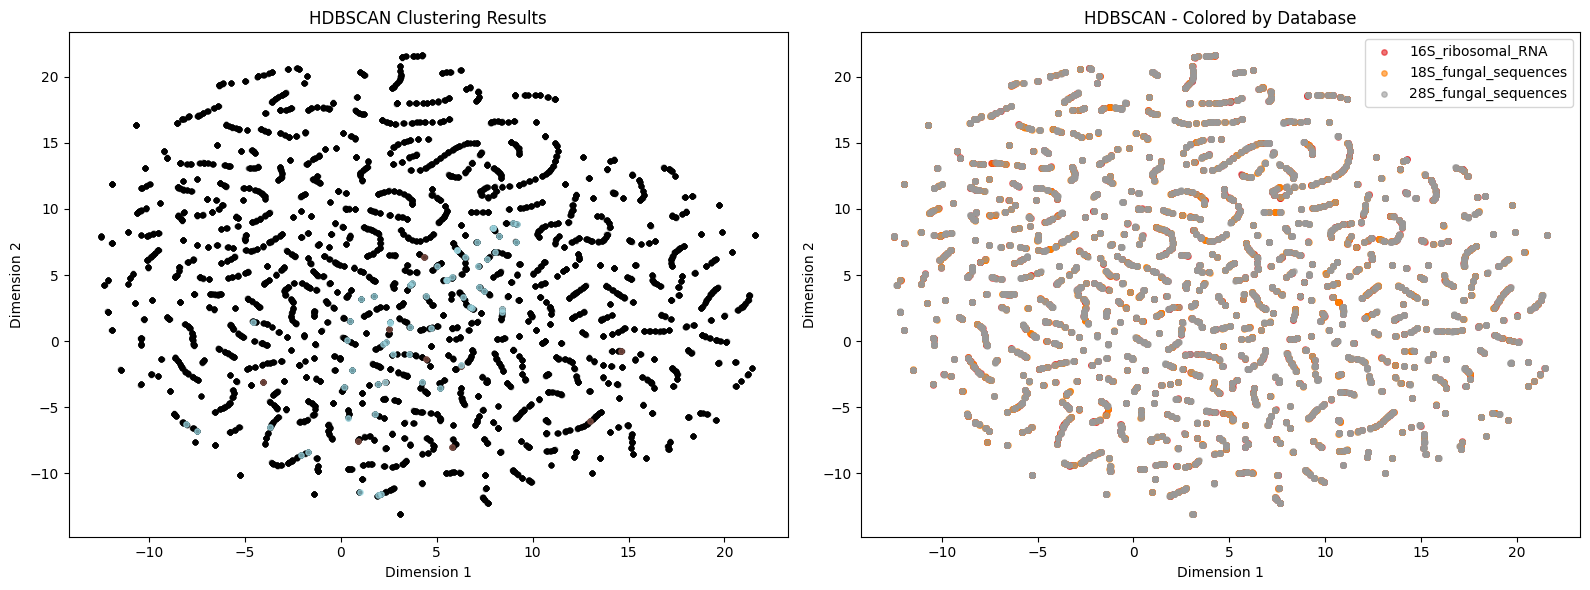


Visualizing DBSCAN results...


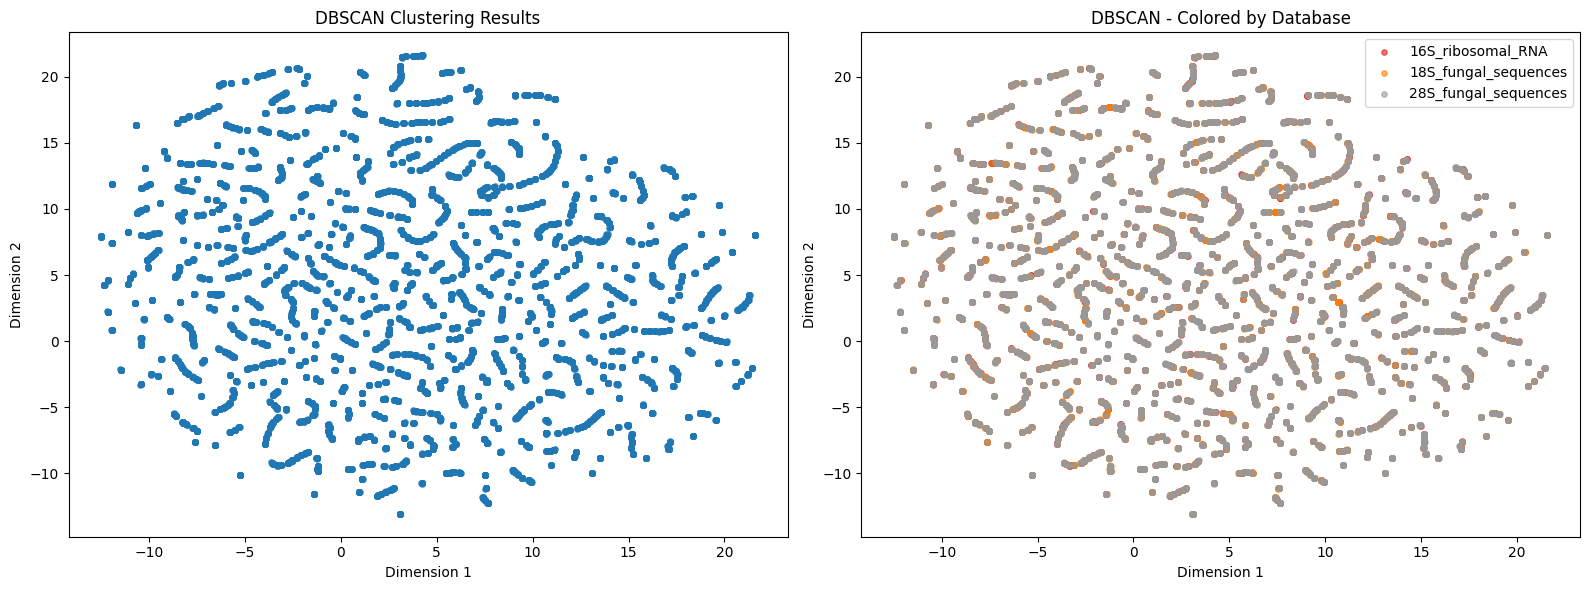


Visualizing KMEANS results...


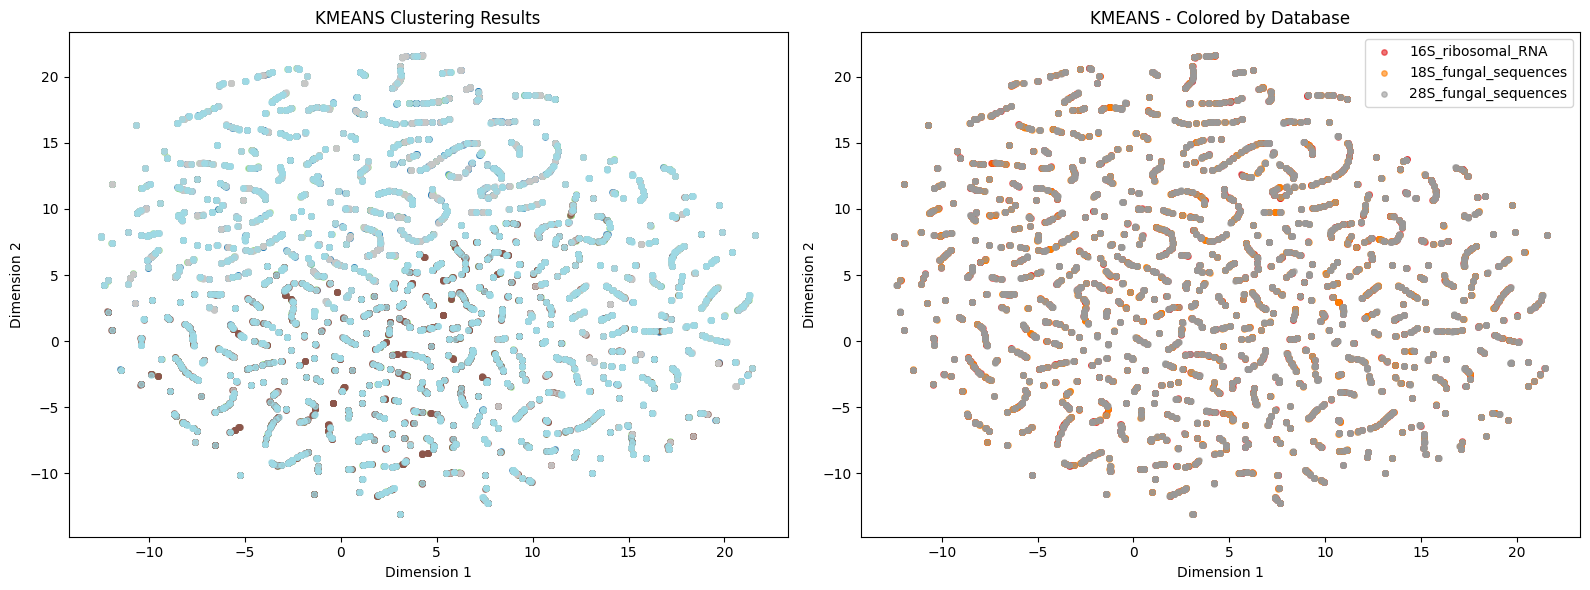


Visualizing GMM results...


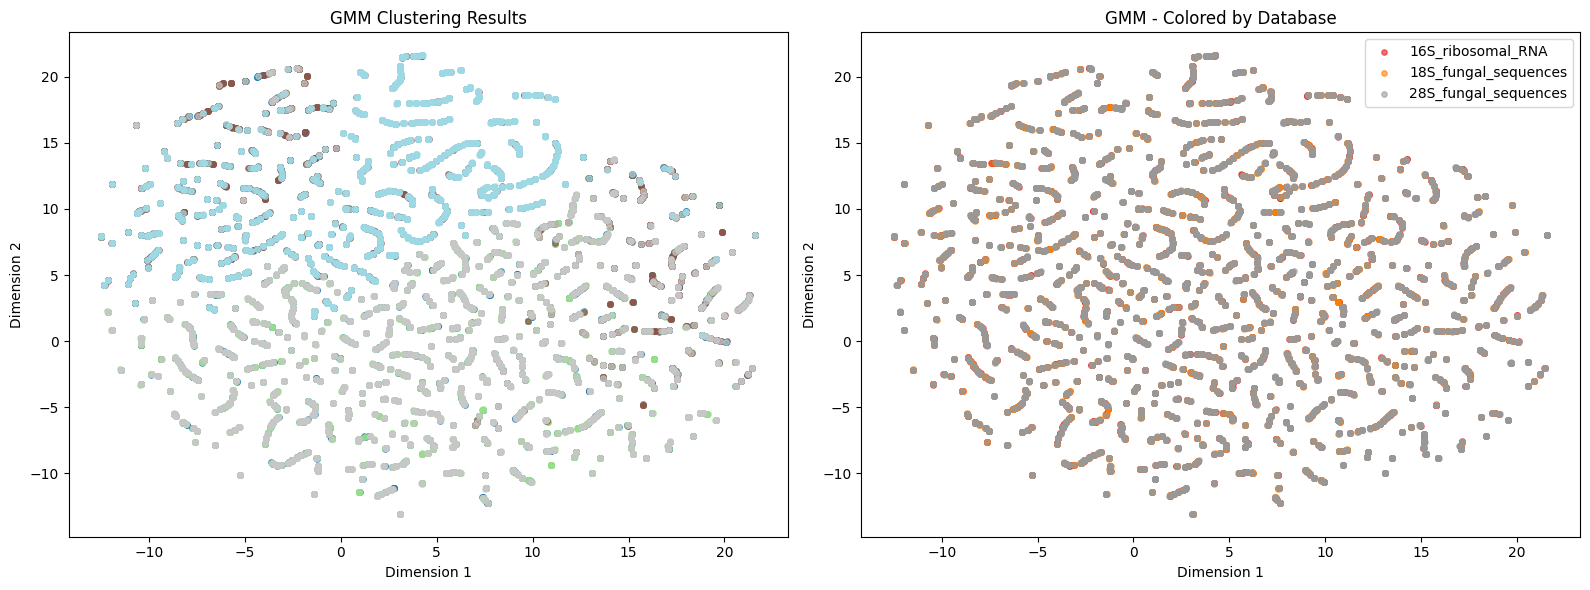

In [6]:
# Visualize clustering results
def plot_clustering_results(embeddings_2d, cluster_labels, method_name, databases):
    """Plot clustering results in 2D space"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Clusters
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Noise points in black
            mask = cluster_labels == label
            axes[0].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                          c='black', alpha=0.5, s=10, label='Noise')
        else:
            mask = cluster_labels == label
            axes[0].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                          c=[colors[i]], alpha=0.7, s=15, label=f'Cluster {label}')
    
    axes[0].set_title(f'{method_name} Clustering Results')
    axes[0].set_xlabel('Dimension 1')
    axes[0].set_ylabel('Dimension 2')
    
    # Plot 2: Colored by database
    db_unique = np.unique(databases)
    db_colors = plt.cm.Set1(np.linspace(0, 1, len(db_unique)))
    db_color_map = dict(zip(db_unique, db_colors))
    
    for db in db_unique:
        mask = np.array(databases) == db
        axes[1].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                       c=[db_color_map[db]], alpha=0.6, s=15, label=db)
    
    axes[1].set_title(f'{method_name} - Colored by Database')
    axes[1].set_xlabel('Dimension 1')
    axes[1].set_ylabel('Dimension 2')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations for each clustering method
print("\n=== Visualizing Clustering Results ===")

for method in ['hdbscan', 'dbscan', 'kmeans', 'gmm']:
    if method in labels_dict:
        print(f"\nVisualizing {method.upper()} results...")
        plot_clustering_results(umap_embeddings, labels_dict[method], method.upper(), databases)

In [10]:
# Select best clustering method and save results
def select_best_clustering_method(cluster_metrics, cluster_summaries):
    """Select the best clustering method based on multiple criteria"""
    
    print("\n=== Selecting Best Clustering Method ===")
    
    scores = {}
    
    for method, metrics in cluster_metrics.items():
        score = 0
        
        # Silhouette score (higher is better)
        if 'silhouette_score' in metrics:
            score += metrics['silhouette_score'] * 0.4
        
        # Number of clusters (prefer moderate number)
        n_clusters = metrics['n_clusters']
        if 5 <= n_clusters <= 50:
            cluster_score = 1.0 - abs(n_clusters - 20) / 20  # Prefer around 20 clusters
            score += cluster_score * 0.3
        
        # Noise ratio (prefer low noise for most methods, but some noise is expected)
        if 'noise_ratio' in metrics:
            noise_ratio = metrics['noise_ratio']
            if noise_ratio < 0.3:  # Prefer less than 30% noise
                noise_score = 1.0 - noise_ratio
                score += noise_score * 0.3
        
        scores[method] = score
        
        print(f"{method.upper()}:")
        print(f"  Score: {score:.3f}")
        print(f"  Clusters: {n_clusters}")
        if 'silhouette_score' in metrics:
            print(f"  Silhouette: {metrics['silhouette_score']:.3f}")
        if 'noise_ratio' in metrics:
            print(f"  Noise ratio: {metrics['noise_ratio']:.3f}")
    
    # Select best method
    best_method = max(scores.keys(), key=lambda k: scores[k])
    print(f"\nBest clustering method: {best_method.upper()}")
    
    return best_method

# Select best method
best_method = select_best_clustering_method(clusterer.cluster_metrics, cluster_summaries)
best_labels = labels_dict[best_method]
best_analyzer = cluster_analyzers[best_method]
best_summary = cluster_summaries[best_method]

# Identify novel clusters
print(f"\n=== Novel Cluster Analysis ({best_method.upper()}) ===")
novel_clusters = best_analyzer.identify_novel_clusters(novelty_threshold=0.4, size_threshold=15)

if len(novel_clusters) > 0:
    print(f"Identified {len(novel_clusters)} potentially novel clusters:")
    print(novel_clusters[['cluster_id', 'size', 'novelty_score', 'dominant_database', 'taxonomic_purity']])
else:
    print("No novel clusters identified with current thresholds")


=== Selecting Best Clustering Method ===
DBSCAN:
  Score: 0.300
  Clusters: 1
  Noise ratio: 0.000
HDBSCAN:
  Score: 0.009
  Clusters: 2
  Silhouette: 0.023
  Noise ratio: 0.995
KMEANS:
  Score: 0.065
  Clusters: 5
  Silhouette: -0.024
GMM:
  Score: 0.060
  Clusters: 5
  Silhouette: -0.038

Best clustering method: DBSCAN

=== Novel Cluster Analysis (DBSCAN) ===
No novel clusters identified with current thresholds


In [11]:
# Save clustering results and models
print("\n=== Saving Clustering Results ===")

# Add cluster labels to sequences dataframe
df_sequences_clustered = df_sequences.copy()
df_sequences_clustered['cluster_id'] = best_labels
df_sequences_clustered['clustering_method'] = best_method

# Add cluster statistics
cluster_stats_dict = {}
for _, row in best_summary.iterrows():
    cluster_stats_dict[row['cluster_id']] = {
        'size': row['size'],
        'novelty_score': row['novelty_score'],
        'dominant_database': row['dominant_database'],
        'avg_length': row['avg_length'],
        'avg_gc_content': row['avg_gc_content']
    }

df_sequences_clustered['cluster_size'] = df_sequences_clustered['cluster_id'].map(
    lambda x: cluster_stats_dict.get(x, {}).get('size', 0)
)
df_sequences_clustered['cluster_novelty'] = df_sequences_clustered['cluster_id'].map(
    lambda x: cluster_stats_dict.get(x, {}).get('novelty_score', 0)
)

# Save clustered sequences
clustered_sequences_file = PROCESSED_DIR / "sequences_clustered.pkl"
with open(clustered_sequences_file, 'wb') as f:
    pickle.dump(df_sequences_clustered, f)
print(f"Saved clustered sequences to: {clustered_sequences_file}")

# Save cluster summaries
cluster_summaries_file = PROCESSED_DIR / "cluster_summaries.pkl"
with open(cluster_summaries_file, 'wb') as f:
    pickle.dump(cluster_summaries, f)
print(f"Saved cluster summaries to: {cluster_summaries_file}")

# Save best clustering results
best_clustering_data = {
    'method': best_method,
    'cluster_labels': best_labels,
    'cluster_summary': best_summary,
    'cluster_analyzer': best_analyzer,
    'novel_clusters': novel_clusters,
    'metrics': clusterer.cluster_metrics[best_method]
}

best_clustering_file = CLUSTER_DIR / "best_clustering_results.pkl"
with open(best_clustering_file, 'wb') as f:
    pickle.dump(best_clustering_data, f)
print(f"Saved best clustering results to: {best_clustering_file}")

# Save all clustering models
clustering_models = {
    'clusterer': clusterer,
    'cluster_analyzers': cluster_analyzers,
    'cluster_metrics': clusterer.cluster_metrics,
    'cluster_results': clusterer.cluster_results
}

models_file = CLUSTER_DIR / "clustering_models.pkl"
with open(models_file, 'wb') as f:
    pickle.dump(clustering_models, f)
print(f"Saved clustering models to: {models_file}")

# Generate consensus sequences for clusters
print("\nGenerating consensus sequences...")
consensus_sequences = {}
for cluster_id in best_summary['cluster_id']:
    consensus_seq = best_analyzer.get_consensus_sequence(cluster_id)
    if consensus_seq:
        consensus_sequences[cluster_id] = consensus_seq

# Save consensus sequences as FASTA
consensus_fasta_file = PROCESSED_DIR / "cluster_consensus_sequences.fasta"
with open(consensus_fasta_file, 'w') as f:
    for cluster_id, seq in consensus_sequences.items():
        cluster_info = best_summary[best_summary['cluster_id'] == cluster_id].iloc[0]
        header = f"cluster_{cluster_id}|size_{cluster_info['size']}|novelty_{cluster_info['novelty_score']:.3f}"
        f.write(f">{header}\n{seq}\n")
print(f"Saved consensus sequences to: {consensus_fasta_file}")

# Export cluster summary as CSV for inspection
csv_file = PROCESSED_DIR / "cluster_summary.csv"
best_summary.to_csv(csv_file, index=False)
print(f"Saved cluster summary CSV to: {csv_file}")

print(f"\n=== Clustering Analysis Complete ===")
print(f"Best method: {best_method.upper()}")
print(f"Number of clusters: {len(best_summary)}")
print(f"Novel clusters identified: {len(novel_clusters)}")
print(f"Sequences clustered: {len(df_sequences_clustered)}")
print(f"Largest cluster size: {best_summary['size'].max()}")
print(f"Average novelty score: {best_summary['novelty_score'].mean():.3f}")
print("\nReady for biodiversity analysis and model training!")


=== Saving Clustering Results ===
Saved clustered sequences to: ../data/processed/sequences_clustered.pkl
Saved clustered sequences to: ../data/processed/sequences_clustered.pkl
Saved cluster summaries to: ../data/processed/cluster_summaries.pkl
Saved cluster summaries to: ../data/processed/cluster_summaries.pkl
Saved best clustering results to: ../model/cluster_models/best_clustering_results.pkl
Saved best clustering results to: ../model/cluster_models/best_clustering_results.pkl
Saved clustering models to: ../model/cluster_models/clustering_models.pkl

Generating consensus sequences...
Saved clustering models to: ../model/cluster_models/clustering_models.pkl

Generating consensus sequences...
Saved consensus sequences to: ../data/processed/cluster_consensus_sequences.fasta
Saved cluster summary CSV to: ../data/processed/cluster_summary.csv

=== Clustering Analysis Complete ===
Best method: DBSCAN
Number of clusters: 1
Novel clusters identified: 0
Sequences clustered: 15000
Largest c